<a href="https://colab.research.google.com/github/NJain121442/course2020/blob/master/Fruits_unsupervised_clustering_conv2_13August_SEM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import torch.nn as nn
import glob
from torch.utils.data import Dataset, DataLoader
import torch
import torch.nn.functional as F
import torch.optim as optim
from IPython.display import clear_output
from torchvision import datasets, transforms
import numpy as np
from torchsummary import summary 
import matplotlib.image as mpimg
import torchvision

In [5]:
from google.colab import drive 
drive.mount("/content/drive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
#!unzip '/content/drive/My Drive/AutoEncoder_training.zip' -d '/content/drive/My Drive/AutoEncoder_training' 

In [7]:
#!unzip /content/Fruits.zip -d /content/

In [8]:
#Data_path = "/content/Fruits/"
Data_path = "/content/drive/My Drive/AutoEncoder_training/AutoEncoder_training/"

In [9]:
#filelist = glob.glob(Data_path+'/*.jfif')
filelist = glob.glob(Data_path+'/*.tiff')

In [10]:
filelist[2]

'/content/drive/My Drive/AutoEncoder_training/AutoEncoder_training/Defect_11285_Class_1_Multi.tiff'

In [11]:
len(filelist)

90

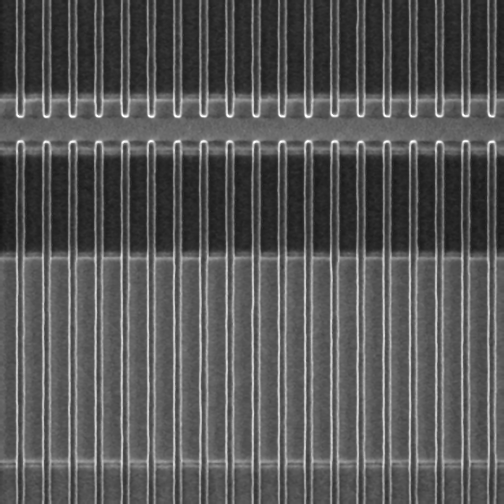

In [12]:
from PIL import Image

Image.open(filelist[88])

(504, 504)


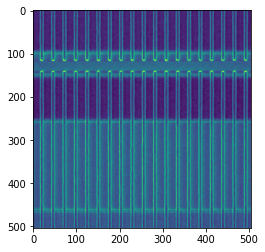

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
img = mpimg.imread(filelist[88])
print(img.shape)
plt.imshow(img)


Original Dimensions :  (504, 504, 3)


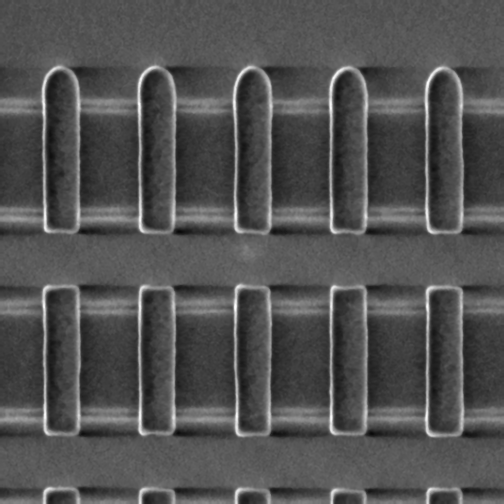

Resized Dimensions :  (504, 504, 3)


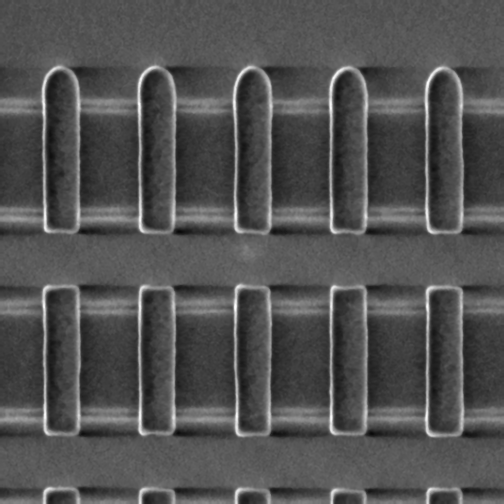

In [14]:
import cv2
from google.colab.patches import cv2_imshow
img = cv2.imread(filelist[9])
print('Original Dimensions : ',img.shape)
cv2_imshow(img)
dim = (504,504)
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
print('Resized Dimensions : ',resized.shape)
cv2_imshow(resized)


Lets Resize all images to same size

In [15]:
class CustomDataset(Dataset):
  def __init__(self,path,new_size = 226):
    #self.filelist = glob.glob(path+'/*.jfif')
    self.filelist = glob.glob(path+'/*.tiff')
    self.new_size = new_size

  def __len__(self):
    return len(self.filelist)

  def __getitem__(self, idx):
    temp_filepath = self.filelist[idx]
    temp_image = cv2.imread(temp_filepath)
    #print(temp_image)
    #print('Original Dimensions : ',temp_image.shape)
    #cv2_imshow(temp_image)
    temp_image = cv2.cvtColor(temp_image, cv2.COLOR_BGR2GRAY)
    #print('Original Dimensions : ',temp_image.shape)
    #cv2_imshow(temp_image)
    #dim = (504,504)
    #temp_image = cv2.resize(temp_image, dim, interpolation = cv2.INTER_AREA)
    #print('Resized Dimensions : ',temp_image.shape)
    #cv2_imshow(temp_image)
    #print(temp_image.shape)
    temp_image = temp_image/255
    #plt.imshow(temp_image,cmap='gray',vmin=0,vmax=1)
    #temp_image = torch.from_numpy(temp_image)
    temp_image = torch.Tensor(temp_image)
    #print(temp_image.shape)
    #print(temp_image)
    temp_image = temp_image.unsqueeze(0)
    #print(temp_image.shape)
    return temp_image

In [16]:
Data = CustomDataset(Data_path)
Data[2].shape

torch.Size([1, 504, 504])

In [17]:
latent_dim = 128

class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.enc1 = nn.Conv2d(1,32,kernel_size=3,stride=3)
        self.enc2 = nn.Conv2d(32,64,kernel_size=3,stride=3)
        self.enc3 = nn.Conv2d(64,128,kernel_size=2,stride=3)
        self.pool = nn.MaxPool2d(2,2,return_indices=True)
        self.FC1 = nn.Linear(3200,1024)
        self.FC2 = nn.Linear(1024,latent_dim)

    def forward(self,x):
        x = F.relu(self.enc1(x)) # output will be 168x168x32
        x,indices1 = self.pool(x) #output will be 84x84x32
        x = F.relu(self.enc2(x)) #output will be 28x28x64
        x,indices2 = self.pool(x)   # output will be 14x14x64
        x = F.relu(self.enc3(x)) #output will be 5x5x128 
        x = x.view(-1,3200) # after flattening the size will be 3200
        x = F.relu(self.FC1(x))
        x = F.relu(self.FC2(x)) # the latent space representation
        return x,indices1,indices2
    
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.FC3 = nn.Linear(latent_dim,1024)
        self.FC4 = nn.Linear(1024,3200)
        self.dec1 = nn.ConvTranspose2d(128,64, kernel_size=2, stride=3)  
        self.dec2 = nn.ConvTranspose2d(64,32, kernel_size=3, stride=3)
        self.dec3 = nn.ConvTranspose2d(32,1, kernel_size=3, stride=3)
        self.unpool = nn.MaxUnpool2d(2,2,padding=0)
        
        
    def forward(self,x,indices1,indices2):
        x = F.relu(self.FC3(x)) #size back to 3200
        x = F.relu(self.FC4(x))
        x = torch.reshape(x,(1,128,5,5))
        x = F.relu(self.dec1(x)) # ouput will be 14x14x64
        x = self.unpool(x,indices2) #output will be 28x28x64
        x = F.relu(self.dec2(x)) # output will be 84x84x32
        x = self.unpool(x,indices1) #output will be 168x168x32
        #x = self.dec3(x) # output will be 504x504x1
        x = torch.sigmoid(self.dec3(x)) # output will be 504x504x1
        return x
    
class Conv2d_AutoEncoder(nn.Module):
    def __init__(self):
        super(Conv2d_AutoEncoder, self).__init__()

        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        
        z,indices1,indices2 = self.enc(x)
        
        out = self.dec(z,indices1,indices2)
        
        return out

**Lets write the first Auto encoder **

In [19]:
net = Conv2d_AutoEncoder()
print(net)
#summary(net,(1,504,504))

Conv2d_AutoEncoder(
  (enc): Encoder(
    (enc1): Conv2d(1, 32, kernel_size=(3, 3), stride=(3, 3))
    (enc2): Conv2d(32, 64, kernel_size=(3, 3), stride=(3, 3))
    (enc3): Conv2d(64, 128, kernel_size=(2, 2), stride=(3, 3))
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (FC1): Linear(in_features=3200, out_features=1024, bias=True)
    (FC2): Linear(in_features=1024, out_features=128, bias=True)
  )
  (dec): Decoder(
    (FC3): Linear(in_features=128, out_features=1024, bias=True)
    (FC4): Linear(in_features=1024, out_features=3200, bias=True)
    (dec1): ConvTranspose2d(128, 64, kernel_size=(2, 2), stride=(3, 3))
    (dec2): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(3, 3))
    (dec3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(3, 3))
    (unpool): MaxUnpool2d(kernel_size=(2, 2), stride=(2, 2), padding=(0, 0))
  )
)


In [20]:
train_loader = DataLoader(Data,batch_size=1)

In [21]:
loss_func = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001) 


current epoch is: 0
Loss Per epoch:  3.2396929748356342
current epoch is: 1
Loss Per epoch:  3.1245018001645803
current epoch is: 2
Loss Per epoch:  3.018770751543343
current epoch is: 3
Loss Per epoch:  2.9264790527522564
current epoch is: 4
Loss Per epoch:  2.840168564580381
current epoch is: 5
Loss Per epoch:  2.7527888156473637
current epoch is: 6
Loss Per epoch:  2.6816733786836267
current epoch is: 7
Loss Per epoch:  2.625446440652013
current epoch is: 8
Loss Per epoch:  2.5754051292315125
current epoch is: 9
Loss Per epoch:  2.529424659907818
current epoch is: 10
Loss Per epoch:  2.486861191689968
current epoch is: 11
Loss Per epoch:  2.4474702635779977
current epoch is: 12
Loss Per epoch:  2.410188727080822
current epoch is: 13
Loss Per epoch:  2.3749322248622775
current epoch is: 14
Loss Per epoch:  2.3386867800727487
current epoch is: 15
Loss Per epoch:  2.2926752250641584
current epoch is: 16
Loss Per epoch:  2.2442583544179797
current epoch is: 17
Loss Per epoch:  2.2052114

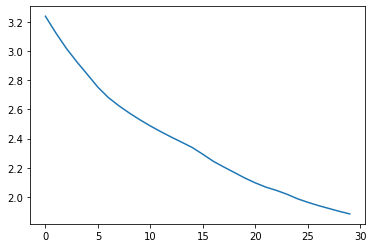

In [22]:
from tqdm.notebook import tqdm
n_epochs = 30

if torch.cuda.is_available():
    net.cuda()
total_loss = []

epoch_loss = 0
net.train()
for epoch in tqdm(range(n_epochs)):
    print("current epoch is:",epoch)
    epoch_loss = 0
    for x in train_loader:
        mse_loss = 0
        if torch.cuda.is_available():
          x = x.cuda()
        optimizer.zero_grad()
        prediction = net(x)
        mse_loss = loss_func(prediction, x) # <-- note that i'm using the input as the target
        epoch_loss = epoch_loss + mse_loss.item()
        mse_loss.backward()
        optimizer.step()
        
    #clear_output(wait=True)
    total_loss.append(epoch_loss)
    print('Loss Per epoch: ',epoch_loss)

import matplotlib.pyplot as plt
plt.plot(total_loss)

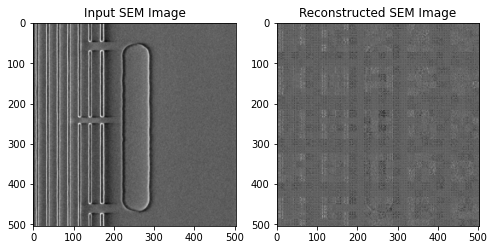

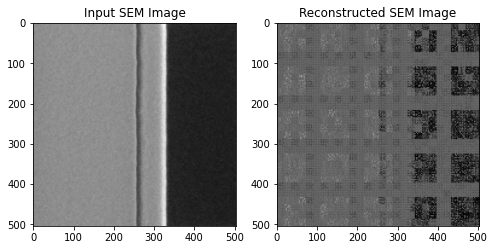

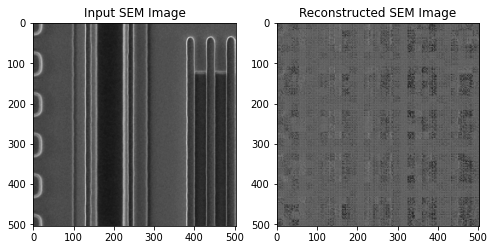

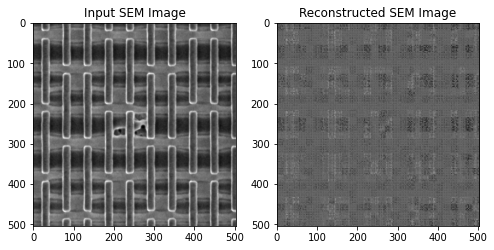

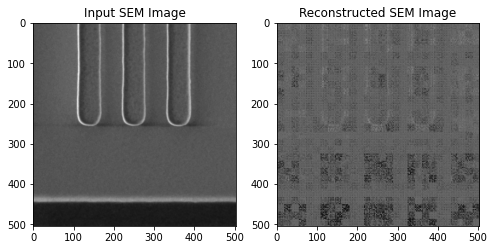

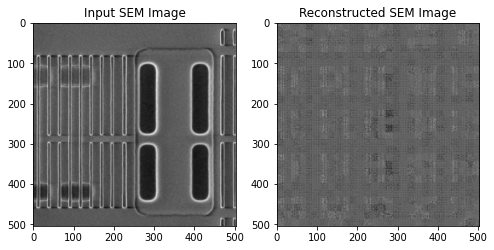

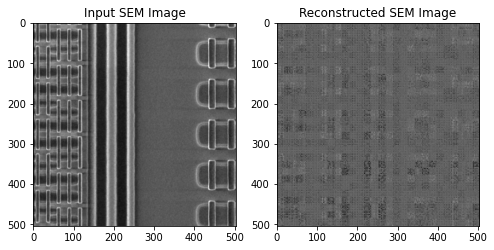

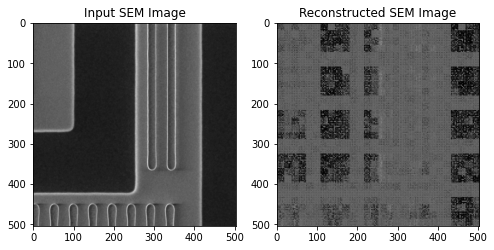

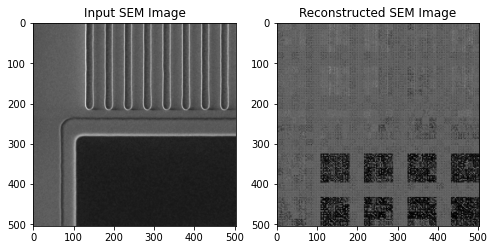

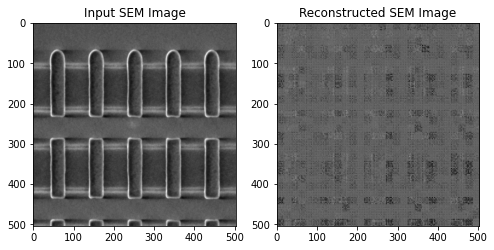

In [23]:
import matplotlib.pyplot as plt

net.cpu()
net.eval()
counter = 0
for i in range(10):
    counter = counter + 1
    fig,ax = plt.subplots(1,2,figsize=(8,4))
    x = Data[i]
    input_img = x[0]
    #print(input_img)
    model_pred = net(x.unsqueeze(0))[0].cpu().data.numpy()[0]
    #print(model_pred)
    ax[0].set_title('Input SEM Image',fontsize=12)
    ax[1].set_title('Reconstructed SEM Image',fontsize=12)
    ax[0].imshow(input_img,cmap='gray',vmin=0,vmax=1)
    ax[1].imshow(model_pred,cmap='gray',vmin=0,vmax=1)


Extract Latent representation from Encoder 

In [37]:
Attributes.shape

(90, 128)

In [127]:
from sklearn.cluster import KMeans
Encoder_net = Encoder()
Attributes = np.empty([len(train_loader),latent_dim])
#print(Attributes.shape)
for i,x in enumerate(Data):
  Temp_results = Encoder_net(x.unsqueeze(0))
  #print(Temp_results[0])
  Temp_Attributes = (Temp_results[0]).cpu().data.numpy()
  #print("Temp_Attributes:",Temp_Attributes)
  Attributes[i] = Temp_Attributes
  #print(Attributes[i].shape)
print(Attributes.shape)

(90, 128)


In [131]:
k=10
kmeans = KMeans(n_clusters=k,random_state=0).fit(Attributes)
Clustering_labels = kmeans.labels_
print(Clustering_labels)

[8 3 6 8 7 4 6 5 9 4 2 0 4 8 2 6 2 9 8 7 6 2 6 2 3 4 4 1 1 6 0 9 6 8 2 2 0
 7 7 5 4 2 1 5 2 0 1 9 1 3 0 8 4 4 4 1 0 8 5 8 2 8 7 8 2 2 6 8 6 4 8 8 4 5
 3 1 7 0 6 7 4 9 2 9 8 2 1 0 4 1]


90


<function matplotlib.pyplot.show>

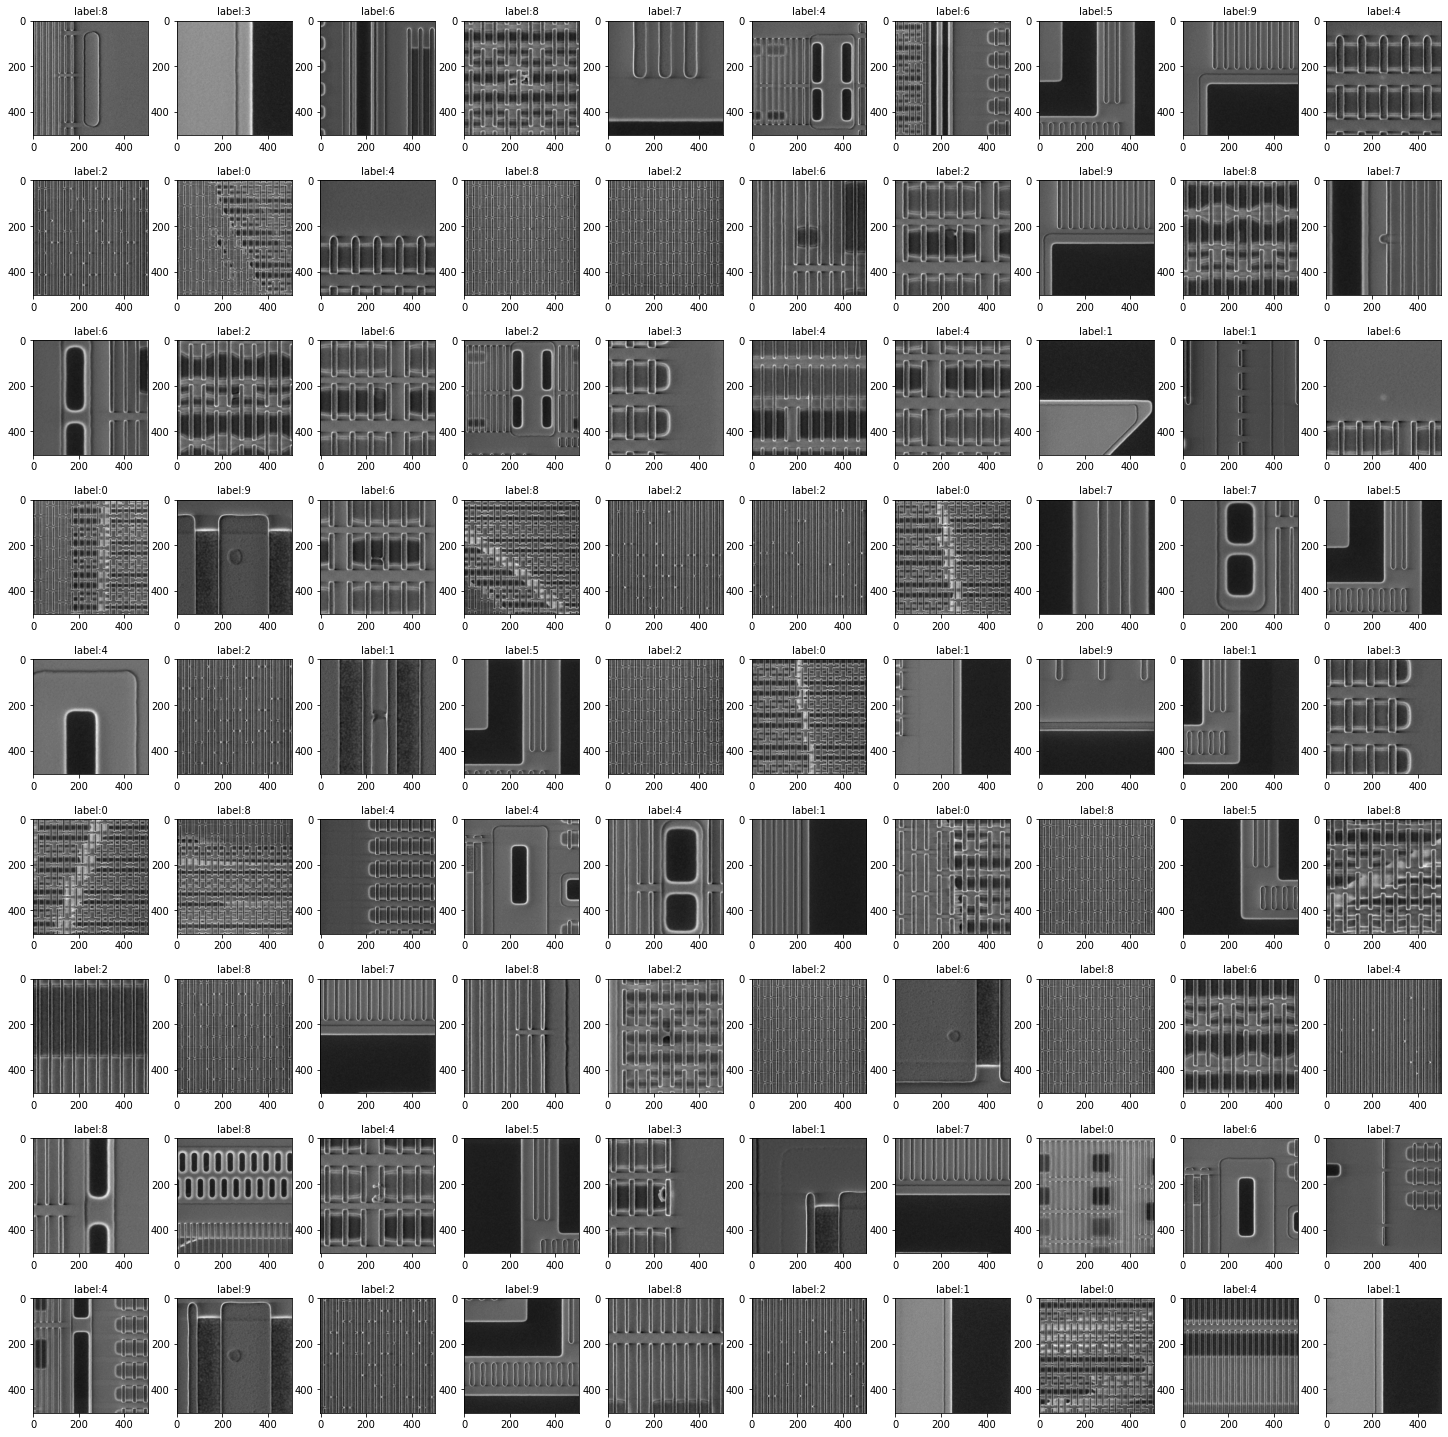

In [135]:
ncols = 10
nrows = int(len(Data)/ncols)
figsize = [20, 20]  
fig,ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
axi = ax.flat
print(len(axi))
for i,x in enumerate(Data):
  input_img = x[0]
  axi[i].set_title("label:"+str(Clustering_labels[i]),fontsize = 10)
  #plt.title('Input SEM Image',fontsize=6)
  axi[i].imshow(input_img,cmap='gray',vmin=0,vmax=1)
fig.tight_layout(pad=0.3)
plt.show

In [85]:
# import pandas as pd
# a =[x for x in Data]

In [90]:
# a =[x.numpy() for x in Data]

In [95]:
# a =[x[0] for x in a]

In [ ]:
# Clustering_labels1, a = zip(*sorted(zip(Clustering_labels, a)))

In [ ]:
# sorted(zip(a, Clustering_labels))

In [103]:
# Clustering_labels1 = Clustering_labels.copy()

In [106]:
# Clustering_labels1 = Clustering_labels.copy()

In [104]:
# Clustering_labels1.sort()

In [ ]:
# zipped_lists = zip(Clustering_labels1, a)
# sorted_pairs = sorted(zipped_lists)
# zipped_lists(0)